In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'peace', 'rock']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [2]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'annot-mueller.json') as f:
        annotations = json.load(f)

In [3]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [4]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
            
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[UID]
        except Exception as e:
            print(e)
            continue
            
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
                
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
                
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
                
            label_index = label_names.index(label)
                
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

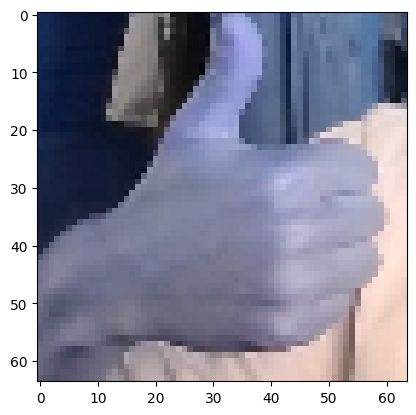

In [5]:
plt.imshow(random.sample(images, 1)[0])

In [6]:
# no_gesture is not included in label_names and was always at pos 2 in label_names
label_names.insert(1, "no_gesture")
label_names

['like', 'no_gesture', 'dislike', 'stop', 'peace', 'rock']

In [7]:
images = np.array(images).astype('float32')
images_norm = images / 255.
images_norm = images_norm.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
images_norm

array([[[[0.07843138, 0.17254902, 0.3647059 ],
         [0.08627451, 0.16078432, 0.3372549 ],
         [0.08235294, 0.14509805, 0.3137255 ],
         ...,
         [0.36862746, 0.42352942, 0.49803922],
         [0.32941177, 0.38431373, 0.45490196],
         [0.22352941, 0.3019608 , 0.41960785]],

        [[0.07843138, 0.16862746, 0.3529412 ],
         [0.08627451, 0.16078432, 0.3372549 ],
         [0.07843138, 0.14509805, 0.30980393],
         ...,
         [0.3647059 , 0.41568628, 0.4862745 ],
         [0.34117648, 0.3882353 , 0.45490196],
         [0.2509804 , 0.31764707, 0.4392157 ]],

        [[0.07450981, 0.16470589, 0.34117648],
         [0.09803922, 0.16470589, 0.33333334],
         [0.07058824, 0.14117648, 0.3019608 ],
         ...,
         [0.38039216, 0.41960785, 0.49803922],
         [0.3529412 , 0.38431373, 0.4509804 ],
         [0.24705882, 0.30980393, 0.41960785]],

        ...,

        [[0.4       , 0.4       , 0.49411765],
         [0.37254903, 0.37254903, 0.46666667]

In [8]:
import keras
model = keras.models.load_model("gesture_recognition")

In [9]:
y_predictions = model.predict(images_norm)

# we get a 2D numpy array with probabilities for each category
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

1/1 [==============================] - 0s 98ms/step
probabilities [0 0 0 2 2 2 3 0 0 0 4 4 5 4 5]


1/1 [==============================] - 0s 25ms/step
before [[9.9999928e-01 6.6948598e-07 8.3960006e-11 3.4203878e-09 1.1224688e-09
  1.6409468e-14]
 [9.8041463e-01 2.7659626e-03 7.3675542e-06 1.6768062e-02 3.0569718e-05
  1.3330121e-05]
 [9.1366702e-01 5.0122600e-02 9.5294305e-04 3.4886289e-02 3.5952224e-04
  1.1655298e-05]
 [5.2823039e-09 9.1575459e-04 9.9908412e-01 3.2589278e-10 7.0015645e-08
  2.1849766e-09]
 [9.5898027e-09 9.0672169e-05 9.9990928e-01 1.3891116e-10 3.1056267e-08
  9.3410966e-11]
 [5.9964663e-08 8.3851386e-03 9.9161482e-01 1.9672556e-12 3.9301695e-09
  3.3044362e-10]
 [4.3864318e-05 1.9141815e-04 4.9051829e-09 9.9976462e-01 3.7601254e-08
  4.2706574e-08]
 [3.8024029e-01 1.3818105e-01 1.5861699e-01 3.1536400e-01 7.4954252e-03
  1.0222835e-04]
 [7.3132527e-01 5.8600068e-02 1.0944465e-02 1.6170481e-01 3.3426583e-02
  3.9987112e-03]
 [9.8955780e-01 2.0568909e-03 6.6516208e-07 8.8756184e-05 8.2958704e-03
  9.9146007e-09]
 [1.6090649e-05 1.7850540e-04 5.4098368e-08 5.31481

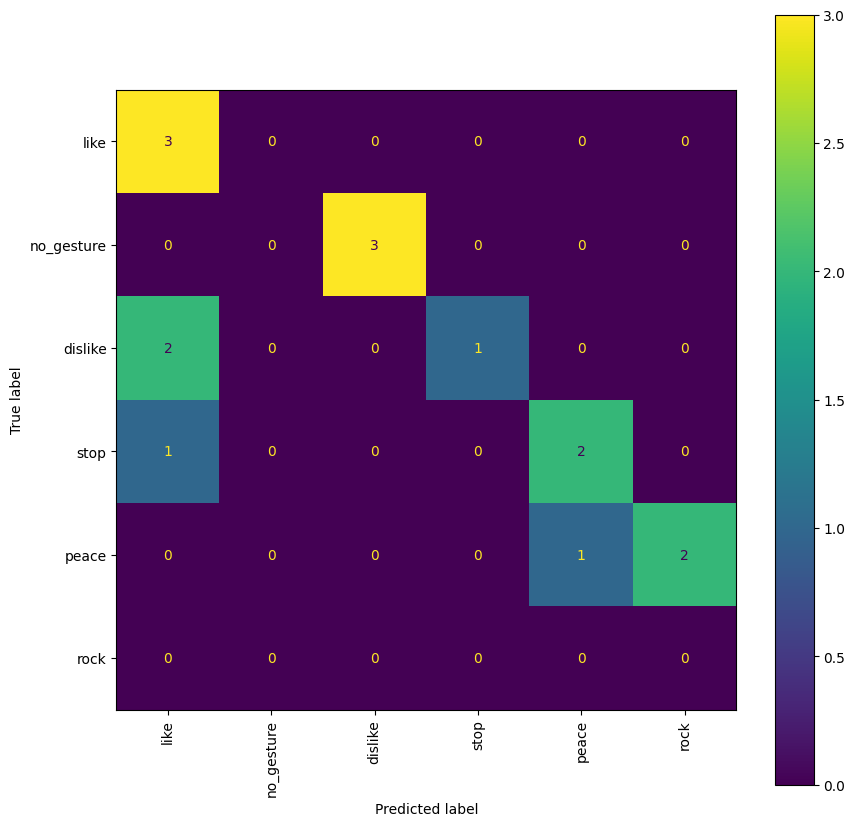

In [10]:
# let the model make predictions for our training data
y_predictions = model.predict(images_norm)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
plt.savefig('conf-matrix.png')
pass

# Model

Model somehow performs really poorly. I tried RandomRotation, since some of my hand gestures in my own annotations are slightly rotated, but it resulted in the same or was even worse.